<a href="https://colab.research.google.com/github/rinermdhn/Sentiment-Analysis-bale-by-btn/blob/main/Sentiment_Analysis_bale_by_btn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Library

!pip install -qq google-play-scraper
!pip install Sastrawi --q
!pip install openpyxl --q
!pip install transformers --q
!pip install tensorflow --q

import json
import pandas as pd
import gdown

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import Sort, reviews, app
from datetime import datetime
from datetime import datetime

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification, BertForSequenceClassification
import tensorflow as tf

# Viz
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

# Inisialisasi
tokenizer = word_tokenize
lemmatizer = WordNetLemmatizer()

import string
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Scraping Data

In [ ]:
# Ambil data
result, continuation_token = reviews(
    'id.co.btn.mobilebanking.android',
    lang='id',
    sort=Sort.NEWEST,
    count=5000
)

# Tentukan batas tanggal dengan jam 13:00
batas_tanggal = datetime(2025, 4, 28, 13, 0)

# Filter hasil berdasarkan tanggal dan jam
filtered_reviews = [review for review in result if review['at'] <= batas_tanggal]

# Ambil 2500 data teratas dari filtered_reviews
results = filtered_reviews[:2500]

In [ ]:
# Hasil Scraping
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2500 non-null   object        
 1   userName              2500 non-null   object        
 2   userImage             2500 non-null   object        
 3   content               2500 non-null   object        
 4   score                 2500 non-null   int64         
 5   thumbsUpCount         2500 non-null   int64         
 6   reviewCreatedVersion  1916 non-null   object        
 7   at                    2500 non-null   datetime64[ns]
 8   replyContent          2500 non-null   object        
 9   repliedAt             2500 non-null   datetime64[ns]
 10  appVersion            1916 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 215.0+ KB


In [ ]:
df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
2495,d736de9a-542a-4828-8915-2622a7aff53b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,MANTAPPP,5,1,None,2024-10-15 06:55:18,Terima kasih Bapak Feby Yanto telah mempercaya...,2024-10-16 05:40:46,None
2496,89388815-a9c8-4bd7-be36-1d56efd58e63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Akhirnya Mobile banking BTN bisa pake fitur si...,5,3,1.11.1,2024-10-15 06:48:07,Terima kasih Ibu Dewi Mardianti telah memperca...,2024-10-16 05:39:46,1.11.1
2497,03d5b3f1-5302-4ed6-b166-94b18c9b2c1d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Apk kagak jelass, pendftaran buat rek baru aja...",1,0,1.11.1,2024-10-15 01:56:01,Bapak/Ibu Youtube Hkun mohon maaf atas ketidak...,2024-10-18 05:45:34,1.11.1
2498,7af64336-187a-4de5-88d2-535257f7d8ef,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sudah bagus, tp lebih baik ditambahkan lagi fi...",4,3,1.11.0,2024-10-14 22:59:22,Terima kasih Bapak david radiant ulasan yang d...,2024-10-15 01:00:42,1.11.0
2499,ba0658ee-2e89-4a10-85a8-ba59aeb131df,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,lagi gangguan ya? masa ga bisa TF,1,0,1.11.1,2024-10-14 14:35:22,Bapak/Ibu Abimaysa Senna mohon maaf atas ketid...,2024-10-18 05:44:58,1.11.1


In [ ]:
df['score'].value_counts()

,count
score,
5,1294
1,817
2,148
3,141
4,100


In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
# Cuplikan 50 ulasan pertama
df['content'].head(50)

,content
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya."
1,terimakasih atas pelayan yg sangat memuaskan
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja"
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja"
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas"
5,udah registrasi ulang..trus di suruh login 180 menit lagi.di coba lgi login suruh registrasi lagi.dah coba live chat jawaban ngg nyambung.di email jg.jawaban sama jg di suruh registrasi lagi..khn udah beberapa x registrasi..payah
6,Mantap
7,sangat lengkap dan mudah
8,"apk nya bagus, tapi baru kali ini saya mengalami kendala tidak bisa masuk/login karena ada warning ada kendala di perangkat ini terdeteksi tidak mengunduh dengan store resmi, padahal saya install nya pake PlayStore, ini maksudnya gimana sih bikin cemas aja lama lama pake BTN.."
9,dari semua bank ini yang paling ribet daftarnya susah acc ada aja kendala dari mulai foto tidak sesuai beneficiary lah kendala pas scan ktp lah ribet banget tinggal acc doang susahnya


# Pre Processing

## Pre Processing (1)

In [ ]:
# Info mengenai data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              2500 non-null   object        
 1   userName              2500 non-null   object        
 2   userImage             2500 non-null   object        
 3   content               2500 non-null   object        
 4   score                 2500 non-null   int64         
 5   thumbsUpCount         2500 non-null   int64         
 6   reviewCreatedVersion  1916 non-null   object        
 7   at                    2500 non-null   datetime64[ns]
 8   replyContent          2500 non-null   object        
 9   repliedAt             2500 non-null   datetime64[ns]
 10  appVersion            1916 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 215.0+ KB


In [ ]:
# Kamus Alay (Indonesian Colloquial)
url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
kamus_alay_df = pd.read_csv(url)
print(kamus_alay_df.head())

# Convert df into dictionary
kamus_alay = dict(zip(kamus_alay_df['slang'], kamus_alay_df['formal']))
print(list(kamus_alay.items())[:10])

     slang    formal  In-dictionary  \
0     woww       wow              1   
1    aminn      amin              1   
2      met   selamat              1   
3   netaas   menetas              1   
4  keberpa  keberapa              0   

                                                                                                                                                      context  \
0                                                                                                                                                         wow   
1  Selamat ulang tahun kakak tulus semoga panjang umur kakak,sehat selalu juga,murah rezeki ya kakak dan jangan sombong kalo sukses di karirnya aminn @tulusm   
2                                                                                                         Met hari netaas kak!? Wish you all the best @tulusm   
3                                                                                                         Met hari netaas

In [ ]:
# Fungsi untuk Pre Processing
def lowercase(review_text):
    return review_text.lower()

def clean_text(review_text):
    # Case folding
    review_text = lowercase(review_text)

    # Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        "]+", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', review_text)

    # Remove hashtags
    cleaned_text = re.sub(r'#\w+', '', cleaned_text)

    # Remove numbers
    cleaned_text = re.sub(r'\d+', ' ', cleaned_text)

    # Remove punctuation
    cleaned_text = cleaned_text.translate(
        str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    )

    # Remove superscript
    superscript_pattern = re.compile("["
        u"\U00002070"
        u"\U000000B9"
        u"\U000000B2-\U000000B3"
        u"\U00002074-\U00002079"
        u"\U0000207A-\U0000207E"
        u"\U0000200D"
        "]+", flags=re.UNICODE)
    cleaned_text = superscript_pattern.sub(r'', cleaned_text)

    # Normalized slang words
    words = cleaned_text.split()
    normalized_words = []
    for word in words:
        lower_word = word.lower()
        if lower_word in kamus_alay:
            normalized_words.append(kamus_alay[lower_word])
        else:
            normalized_words.append(word)
    cleaned_text = ' '.join(normalized_words)

    # Remove character repetition
    cleaned_text = re.sub(r'(.)\1+', r'\1', cleaned_text)

    # Remove word repetition
    cleaned_text = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1', cleaned_text, flags=re.IGNORECASE)

    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Stopwords Removal (without tokenization)
    stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg",
                "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh", "engak", "gue",
                "gua", "gweh", "lu", "lw"]

    # Split, filter stopwords, and rejoin as a string
    words = cleaned_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [ ]:
# Apply Preprocessing (1)
df['preprocessing'] = df['content'].apply(clean_text)

# Hasil Preprocessing
df[['content', 'preprocessing']]

,content,preprocessing
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya.",notifikasi aplikasi ilegal coba bale btn dihapus instal ulang username lupa klik lupa id siapkan kartu atm isi data pulsa minimal pastikan mpin coba login jam pastikan jaringan lancar pengalaman indak berhasil langsung banknya
1,terimakasih atas pelayan yg sangat memuaskan,terimakasih pelayan memuaskan
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja",antre bikin rekening daftar isi formulir daftar eror aplikasinya buang
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja",nih registrasi susah kartu dibilang beda bikin ribet
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas",bayar service ac apk bybtn dah janji tukang ac konfirmasi duit dibatalin penipuan pesan
...,...,...
2495,"BTN mobil bebas biaya transfer. Login pakai sidik jari/face id yang meningkatkan keamanan, rekomendasi bgt deh!",btn mobil bebas biaya transfer login pakai sidik jari face id meningkatkan keamanan rekomendasi banget deh
2496,"aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun, top up saldo yang mudah dan sangat praktis, serta bisa log in menggunakan sidik / face id.. mantap😍",aplikasi btn mobile banking mudah aman dimanapun top saldo mudah praktis log mengunakan sidik face id mantap
2497,Aku suka banget sama BTN mobile Karna bebas biaya transfer. Apalagi disini banyak promo nya. Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM. Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id. Jadi bisa makin aman. Mangkannya aku suka banget sama BTN mobile. Gak perlu di ragukan lagi,suka banget btn mobile bebas biaya transfer promo suka tarik tunai kartu atm oh iya aplikasi btn mobile pakai sidik jari face id aman mangkanya suka banget btn mobile ragukan
2498,"Bisa buka rekening dari hp jadi lebih mudah,top up dari e-wallet dan bisa tarik tunai tanpa kartu,bebas biaya transfer dan bisa jadwal transfer otomatis.aplikasinya aman bisa login pake sidik jari pula,bisa bayar tagihan dan banyak promo.pokoknya aplikasi mobile banking btn ini udah lengkap dech semua....",buka rekening hp mudah top e walet tarik tunai kartu bebas biaya transfer jadwal transfer otomatis aplikasinya aman login pakai sidik jari bayar tagihan promo pokoknya aplikasi mobile banking btn lengkap deh


In [ ]:
df2 = df[['content', 'preprocessing','score']]

In [ ]:
# Drop rows dengan missing value pada kolom 'content'
df2.dropna(subset=['preprocessing'], inplace=True)

# Drop baris yang duplikat
df2.drop_duplicates(subset=['preprocessing'], keep='first', inplace=True)

In [ ]:
df2

,content,preprocessing,score
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya.",notifikasi aplikasi ilegal coba bale btn dihapus instal ulang username lupa klik lupa id siapkan kartu atm isi data pulsa minimal pastikan mpin coba login jam pastikan jaringan lancar pengalaman indak berhasil langsung banknya,1
1,terimakasih atas pelayan yg sangat memuaskan,terimakasih pelayan memuaskan,5
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja",antre bikin rekening daftar isi formulir daftar eror aplikasinya buang,1
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja",nih registrasi susah kartu dibilang beda bikin ribet,1
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas",bayar service ac apk bybtn dah janji tukang ac konfirmasi duit dibatalin penipuan pesan,1
...,...,...,...
2495,"BTN mobil bebas biaya transfer. Login pakai sidik jari/face id yang meningkatkan keamanan, rekomendasi bgt deh!",btn mobil bebas biaya transfer login pakai sidik jari face id meningkatkan keamanan rekomendasi banget deh,5
2496,"aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun, top up saldo yang mudah dan sangat praktis, serta bisa log in menggunakan sidik / face id.. mantap😍",aplikasi btn mobile banking mudah aman dimanapun top saldo mudah praktis log mengunakan sidik face id mantap,5
2497,Aku suka banget sama BTN mobile Karna bebas biaya transfer. Apalagi disini banyak promo nya. Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM. Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id. Jadi bisa makin aman. Mangkannya aku suka banget sama BTN mobile. Gak perlu di ragukan lagi,suka banget btn mobile bebas biaya transfer promo suka tarik tunai kartu atm oh iya aplikasi btn mobile pakai sidik jari face id aman mangkanya suka banget btn mobile ragukan,5
2498,"Bisa buka rekening dari hp jadi lebih mudah,top up dari e-wallet dan bisa tarik tunai tanpa kartu,bebas biaya transfer dan bisa jadwal transfer otomatis.aplikasinya aman bisa login pake sidik jari pula,bisa bayar tagihan dan banyak promo.pokoknya aplikasi mobile banking btn ini udah lengkap dech semua....",buka rekening hp mudah top e walet tarik tunai kartu bebas biaya transfer jadwal transfer otomatis aplikasinya aman login pakai sidik jari bayar tagihan promo pokoknya aplikasi mobile banking btn lengkap deh,5


## Preprocessing (2)

In [ ]:
df_eda = df2.copy()
def preprocess_eda(text):
    # Convert text to lowercase for case-insensitive matching
    text = text.lower()

    # Remove specific words - expanded list with word boundaries
    text = re.sub(r'\b(aplikasi|btn|mobile|aplikasinya|bale|apk|banget|kali|ya|bank)\b', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Stopwords Removal (without tokenization)
    stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg",
                "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh", "engak", "gue",
                "gua", "gweh", "lu", "lw"]

    # Split, filter stopwords, and rejoin as a string
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)

    return text

df_eda['eda'] = df_eda['content'].apply(preprocess_eda)
df_eda.head()

## Preprocessing (3)

In [ ]:
def clean_text(review_text):
    # Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        "]+", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', review_text)

    # Remove hashtags
    cleaned_text = re.sub(r'#\w+', '', cleaned_text)

    # Remove numbers
    cleaned_text = re.sub(r'\d+', ' ', cleaned_text)

    # Remove punctuation
    cleaned_text = cleaned_text.translate(
        str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    )

    # Remove superscript
    superscript_pattern = re.compile("["
        u"\U00002070"
        u"\U000000B9"
        u"\U000000B2-\U000000B3"
        u"\U00002074-\U00002079"
        u"\U0000207A-\U0000207E"
        u"\U0000200D"
        "]+", flags=re.UNICODE)
    cleaned_text = superscript_pattern.sub(r'', cleaned_text)

    # Normalized slang words
    words = cleaned_text.split()
    normalized_words = []
    for word in words:
        lower_word = word.lower()  # Just for checking against dictionary
        if lower_word in kamus_alay:
            normalized_words.append(kamus_alay[lower_word])
        else:
            normalized_words.append(word)  # Keep original case
    cleaned_text = ' '.join(normalized_words)

    # Remove character repetition
    cleaned_text = re.sub(r'(.)\1+', r'\1', cleaned_text)

    # Remove word repetition
    cleaned_text = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1', cleaned_text, flags=re.IGNORECASE)

    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [ ]:
# Apply Preprocessing
df3 = df.copy()
df3['preprocessing'] = df3['content'].apply(clean_text)
df3[['content', 'preprocessing']]

,content,preprocessing
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya.",Bagi yang tiba ada notifikasi aplikasi ilegal coba bale by BTN dihapus kemudian instal ulang Bagi yang username lupa bisa klik lupa ID Siapkan kartu ATM untuk isi data dan pulsa minimal ke Pastikan ingat MPIN Coba login lagi setelah jam Pastikan jaringan lancar Ini dari pengalaman saja kalau indak berhasil bisa langsung datang ke banknya
1,terimakasih atas pelayan yg sangat memuaskan,terimakasih atas pelayan yang sangat memuaskan
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja",sudah antre bikin rekening sudah daftar isi formulir macam engak bisa daftar karena eror aplikasinya buang waktu saja
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja",bagaimana Sih Nih Mau Registrasi saja Susah benar No Kartu saja benar kok Masa Dibilang Beda Bikin Ribet saja
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas",sudah bayar mau service ac lewat apk byBTN dah buat janji tapi tukang ac nya engak ada konfirmasi sama sekali Duit engak balik engak bisa dibatalin juga Penipuan jangan pesan lewat sini engak jelas
...,...,...
2495,"BTN mobil bebas biaya transfer. Login pakai sidik jari/face id yang meningkatkan keamanan, rekomendasi bgt deh!",BTN mobil bebas biaya transfer Login pakai sidik jari face id yang meningkatkan keamanan rekomendasi banget deh
2496,"aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun, top up saldo yang mudah dan sangat praktis, serta bisa log in menggunakan sidik / face id.. mantap😍",aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun top up saldo yang mudah dan sangat praktis serta bisa log ini mengunakan sidik face id mantap
2497,Aku suka banget sama BTN mobile Karna bebas biaya transfer. Apalagi disini banyak promo nya. Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM. Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id. Jadi bisa makin aman. Mangkannya aku suka banget sama BTN mobile. Gak perlu di ragukan lagi,Aku suka banget sama BTN mobile karena bebas biaya transfer Apalagi disini banyak promo nya Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id Jadi bisa makin aman Mangkanya aku suka banget sama BTN mobile engak perlu di ragukan lagi
2498,"Bisa buka rekening dari hp jadi lebih mudah,top up dari e-wallet dan bisa tarik tunai tanpa kartu,bebas biaya transfer dan bisa jadwal transfer otomatis.aplikasinya aman bisa login pake sidik jari pula,bisa bayar tagihan dan banyak promo.pokoknya aplikasi mobile banking btn ini udah lengkap dech semua....",Bisa buka rekening dari hp jadi lebih mudah top up dari e walet dan bisa tarik tunai tanpa kartu bebas biaya transfer dan bisa jadwal transfer otomatis aplikasinya aman bisa login pakai sidik jari pula bisa bayar tagihan dan banyak promo pokoknya aplikasi mobile banking btn ini sudah lengkap deh semua


In [ ]:
df3 = df3[['content', 'preprocessing','score']]

In [ ]:
# Menghapus baris dengan nilai yang hilang di kolom 'preprocessing'
df3.dropna(subset=['preprocessing'], inplace=True)

# Menghapus baris yang hanya berisi spasi kosong
df3 = df3[df3['preprocessing'].str.strip() != '']

# Menghapus baris duplikat, menyimpan kemunculan pertama
df3.drop_duplicates(subset=['preprocessing'], keep='first', inplace=True)

In [ ]:
df3

,content,preprocessing,score
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya.",Bagi yang tiba ada notifikasi aplikasi ilegal coba bale by BTN dihapus kemudian instal ulang Bagi yang username lupa bisa klik lupa ID Siapkan kartu ATM untuk isi data dan pulsa minimal ke Pastikan ingat MPIN Coba login lagi setelah jam Pastikan jaringan lancar Ini dari pengalaman saja kalau indak berhasil bisa langsung datang ke banknya,1
1,terimakasih atas pelayan yg sangat memuaskan,terimakasih atas pelayan yang sangat memuaskan,5
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja",sudah antre bikin rekening sudah daftar isi formulir macam engak bisa daftar karena eror aplikasinya buang waktu saja,1
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja",bagaimana Sih Nih Mau Registrasi saja Susah benar No Kartu saja benar kok Masa Dibilang Beda Bikin Ribet saja,1
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas",sudah bayar mau service ac lewat apk byBTN dah buat janji tapi tukang ac nya engak ada konfirmasi sama sekali Duit engak balik engak bisa dibatalin juga Penipuan jangan pesan lewat sini engak jelas,1
...,...,...,...
2495,"BTN mobil bebas biaya transfer. Login pakai sidik jari/face id yang meningkatkan keamanan, rekomendasi bgt deh!",BTN mobil bebas biaya transfer Login pakai sidik jari face id yang meningkatkan keamanan rekomendasi banget deh,5
2496,"aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun, top up saldo yang mudah dan sangat praktis, serta bisa log in menggunakan sidik / face id.. mantap😍",aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun top up saldo yang mudah dan sangat praktis serta bisa log ini mengunakan sidik face id mantap,5
2497,Aku suka banget sama BTN mobile Karna bebas biaya transfer. Apalagi disini banyak promo nya. Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM. Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id. Jadi bisa makin aman. Mangkannya aku suka banget sama BTN mobile. Gak perlu di ragukan lagi,Aku suka banget sama BTN mobile karena bebas biaya transfer Apalagi disini banyak promo nya Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id Jadi bisa makin aman Mangkanya aku suka banget sama BTN mobile engak perlu di ragukan lagi,5
2498,"Bisa buka rekening dari hp jadi lebih mudah,top up dari e-wallet dan bisa tarik tunai tanpa kartu,bebas biaya transfer dan bisa jadwal transfer otomatis.aplikasinya aman bisa login pake sidik jari pula,bisa bayar tagihan dan banyak promo.pokoknya aplikasi mobile banking btn ini udah lengkap dech semua....",Bisa buka rekening dari hp jadi lebih mudah top up dari e walet dan bisa tarik tunai tanpa kartu bebas biaya transfer dan bisa jadwal transfer otomatis aplikasinya aman bisa login pakai sidik jari pula bisa bayar tagihan dan banyak promo pokoknya aplikasi mobile banking btn ini sudah lengkap deh semua,5


## Labelling

In [ ]:
# Labelling berdasarkan skor
df3['sentiment'] = df3['score'].apply(lambda x: 'positif' if x >= 4 else 'negatif')
df3

,content,preprocessing,score,sentiment
0,"Bagi yang tiba tiba ada notifikasi aplikasi illegal coba bale by BTN dihapus kemudian install ulang. Bagi yang username lupa, bisa klik lupa ID. Siapkan kartu ATM untuk isi data dan pulsa minimal 1k. Pastikan ingat MPIN. Coba login lagi setelah 4 jam. Pastikan jaringan lancar Ini dari pengalaman aja, kalau nda berhasil bisa langsung datang ke banknya.",Bagi yang tiba ada notifikasi aplikasi ilegal coba bale by BTN dihapus kemudian instal ulang Bagi yang username lupa bisa klik lupa ID Siapkan kartu ATM untuk isi data dan pulsa minimal ke Pastikan ingat MPIN Coba login lagi setelah jam Pastikan jaringan lancar Ini dari pengalaman saja kalau indak berhasil bisa langsung datang ke banknya,1,negatif
1,terimakasih atas pelayan yg sangat memuaskan,terimakasih atas pelayan yang sangat memuaskan,5,positif
2,"udh antre bikin rekening, udh daftar isi formulir macem2, ga bisa daftar Krn eror aplikasinya. buang2 waktu aja",sudah antre bikin rekening sudah daftar isi formulir macam engak bisa daftar karena eror aplikasinya buang waktu saja,1,negatif
3,"gimana Sih Nih Mau Registrasi aja Susah Bener,No Kartu aja Bener Ko Masa Dibilang Beda... Bikin Ribet aja",bagaimana Sih Nih Mau Registrasi saja Susah benar No Kartu saja benar kok Masa Dibilang Beda Bikin Ribet saja,1,negatif
4,"udah bayar mau service ac lewat apk byBTN dh buat janji tp tukang ac nya gda konfirmasi sma sekali Duit ga balik ga bisa dibatalin juga, Penipuan jangan pesen"" lewat sini ga jelas",sudah bayar mau service ac lewat apk byBTN dah buat janji tapi tukang ac nya engak ada konfirmasi sama sekali Duit engak balik engak bisa dibatalin juga Penipuan jangan pesan lewat sini engak jelas,1,negatif
...,...,...,...,...
2495,"BTN mobil bebas biaya transfer. Login pakai sidik jari/face id yang meningkatkan keamanan, rekomendasi bgt deh!",BTN mobil bebas biaya transfer Login pakai sidik jari face id yang meningkatkan keamanan rekomendasi banget deh,5,positif
2496,"aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun, top up saldo yang mudah dan sangat praktis, serta bisa log in menggunakan sidik / face id.. mantap😍",aplikasi BTN mobile banking yang mudah dan aman bisa di gunakan kapan pun dan dimanapun top up saldo yang mudah dan sangat praktis serta bisa log ini mengunakan sidik face id mantap,5,positif
2497,Aku suka banget sama BTN mobile Karna bebas biaya transfer. Apalagi disini banyak promo nya. Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM. Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id. Jadi bisa makin aman. Mangkannya aku suka banget sama BTN mobile. Gak perlu di ragukan lagi,Aku suka banget sama BTN mobile karena bebas biaya transfer Apalagi disini banyak promo nya Apalagi yang paling aku suka itu tarik tunai tanpa kartu ATM Oh iya di aplikasi BTN mobile juga pakai sidik jari atau face id Jadi bisa makin aman Mangkanya aku suka banget sama BTN mobile engak perlu di ragukan lagi,5,positif
2498,"Bisa buka rekening dari hp jadi lebih mudah,top up dari e-wallet dan bisa tarik tunai tanpa kartu,bebas biaya transfer dan bisa jadwal transfer otomatis.aplikasinya aman bisa login pake sidik jari pula,bisa bayar tagihan dan banyak promo.pokoknya aplikasi mobile banking btn ini udah lengkap dech semua....",Bisa buka rekening dari hp jadi lebih mudah top up dari e walet dan bisa tarik tunai tanpa kartu bebas biaya transfer dan bisa jadwal transfer otomatis aplikasinya aman bisa login pakai sidik jari pula bisa bayar tagihan dan banyak promo pokoknya aplikasi mobile banking btn ini sudah lengkap deh semua,5,positif


In [ ]:
# Export ke Excel
df3.to_excel('reviews_sentiment.xlsx', index=False)

### Validasi manual

In [ ]:
# Load Data (Preprocessing 1)
!gdown 196t8WbXbydGnOp38mdd4kY0IxroREHzU
data1 = pd.read_csv('/content/status ulasan - Sheet1.csv')

Downloading...
From: https://drive.google.com/uc?id=196t8WbXbydGnOp38mdd4kY0IxroREHzU
To: /content/status ulasan - Sheet1.csv
100% 190k/190k [00:00<00:00, 4.88MB/s]


In [ ]:
data1 = data1[['content', 'sentiment']]
data1.head()

,content,sentiment
0,notifikasi aplikasi ilegal coba bale btn dihap...,negatif
1,antre bikin rekening daftar isi formulir dafta...,negatif
2,nih registrasi susah kartu dibilang beda bikin...,negatif
3,bayar service ac apk bybtn dah janji tukang ac...,negatif
4,registrasi ulang suruh login menit coba login ...,negatif


In [ ]:
# Encode labels
data1['label'] = data1['sentiment'].replace({'negatif': 0, 'positif': 1})
data1

<ipython-input-26-5462cf646ac7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['sentiment'].replace({'negatif': 0, 'positif': 1})


,content,sentiment,label
0,notifikasi aplikasi ilegal coba bale btn dihap...,negatif,0
1,antre bikin rekening daftar isi formulir dafta...,negatif,0
2,nih registrasi susah kartu dibilang beda bikin...,negatif,0
3,bayar service ac apk bybtn dah janji tukang ac...,negatif,0
4,registrasi ulang suruh login menit coba login ...,negatif,0
...,...,...,...
2275,aplikasinya membantu banget bayar tagihan tran...,positif,1
2276,kalo buka rekening btn apknya praktis banget l...,positif,1
2277,mbanking btn nih enak pakeknya enaknya buka re...,positif,1
2278,aplikasi btn mobile mudah biaya transfer bebas...,positif,1


In [ ]:
# Load Data (Preprocessing 3)
!gdown 16ANsWg8DwxnftxrEMc3LkpNwSUuj2vCH
data = pd.read_excel('/content/status ulasan.xlsx')

Downloading...
From: https://drive.google.com/uc?id=16ANsWg8DwxnftxrEMc3LkpNwSUuj2vCH
To: /content/status ulasan.xlsx
100% 227k/227k [00:00<00:00, 82.6MB/s]


In [ ]:
data = data[['preprocessing', 'sentiment']]
data.head()

,preprocessing,sentiment
0,Bagi yang tiba ada notifikasi aplikasi ilegal ...,negatif
1,sudah antre bikin rekening sudah daftar isi fo...,negatif
2,bagaimana Sih Nih Mau Registrasi saja Susah be...,negatif
3,sudah bayar mau service ac lewat apk byBTN dah...,negatif
4,sudah registrasi ulang terus di suruh login me...,negatif


In [ ]:
# Encode label
data.rename(columns={'preprocessing': 'content'}, inplace=True)
data['label'] = data['sentiment'].replace({'negatif': 0, 'positif': 1})
data

<ipython-input-4-45b2cd37cf66>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['sentiment'].replace({'negatif': 0, 'positif': 1})


,content,sentiment,label
0,Bagi yang tiba ada notifikasi aplikasi ilegal ...,negatif,0
1,sudah antre bikin rekening sudah daftar isi fo...,negatif,0
2,bagaimana Sih Nih Mau Registrasi saja Susah be...,negatif,0
3,sudah bayar mau service ac lewat apk byBTN dah...,negatif,0
4,sudah registrasi ulang terus di suruh login me...,negatif,0
...,...,...,...
2342,Aplikasi BTN mobile banking sangat membantu pe...,positif,1
2343,BTN mobil bebas biaya transfer Login pakai sid...,positif,1
2344,aplikasi BTN mobile banking yang mudah dan ama...,positif,1
2345,Aku suka banget sama BTN mobile karena bebas b...,positif,1


# EDA

## Preprocessing (1)

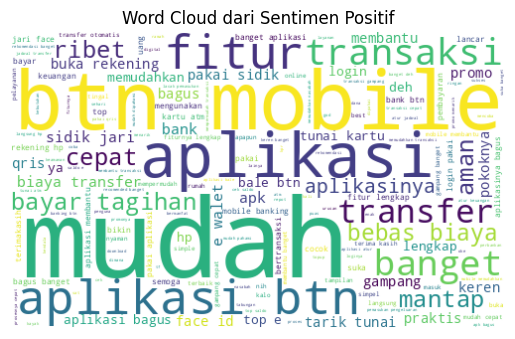

In [ ]:
df_positif = data1[data1['sentiment'] == 'positif']
all_words_positif = ' '.join([twts for twts in df_positif['content']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110, background_color='white').generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

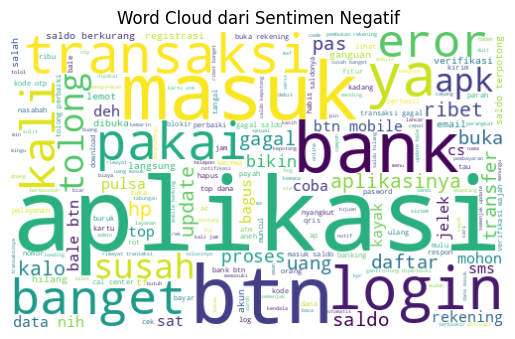

In [ ]:
df_positif = data1[data1['sentiment'] == 'negatif']
all_words_positif = ' '.join([twts for twts in df_positif['content']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110, background_color='white').generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

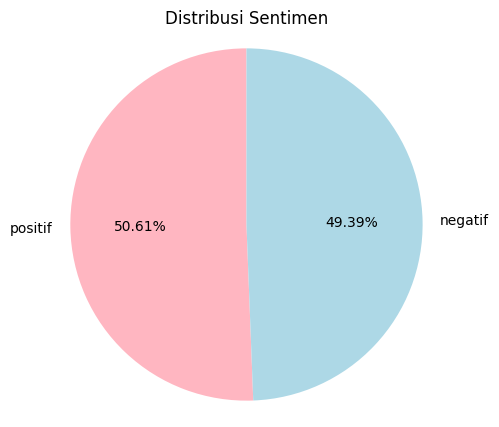

In [ ]:
sentiment_counts = data1['sentiment'].value_counts()

# Colors
colors = ['#FFB6C1', '#ADD8E6']  # Light pink, light blue

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Preprocessing (2)

In [ ]:
df_eda = data.copy()

In [ ]:
def preprocess_eda(text):
    # Convert text to lowercase for case-insensitive matching
    text = text.lower()

    # Remove specific words - expanded list with word boundaries
    text = re.sub(r'\b(aplikasi|btn|mobile|aplikasinya|bale|apk|banget|kali|ya|bank)\b', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Stopwords Removal (without tokenization)
    stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg",
                "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh", "engak", "gue",
                "gua", "gweh", "lu", "lw"]

    # Split, filter stopwords, and rejoin as a string
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)

    return text

df_eda['eda'] = df_eda['content'].apply(preprocess_eda)
df_eda.head()

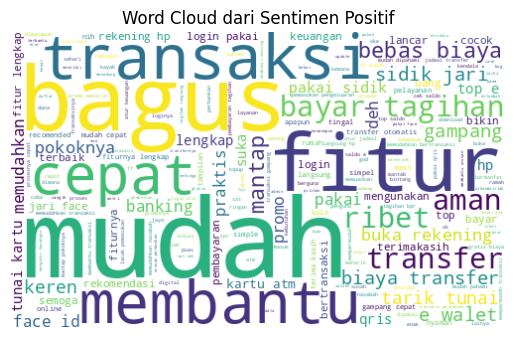

In [ ]:
df_positif = df_eda[df_eda['sentiment'] == 'positif']
all_words_positif = ' '.join([twts for twts in df_positif['eda']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110, background_color='white').generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

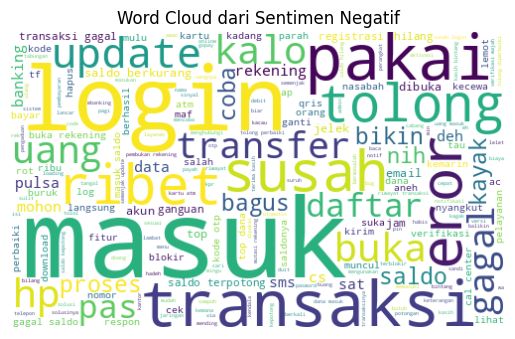

In [ ]:
df_positif = df_eda[df_eda['sentiment'] == 'negatif']
all_words_positif = ' '.join([twts for twts in df_positif['eda']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110, background_color='white').generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

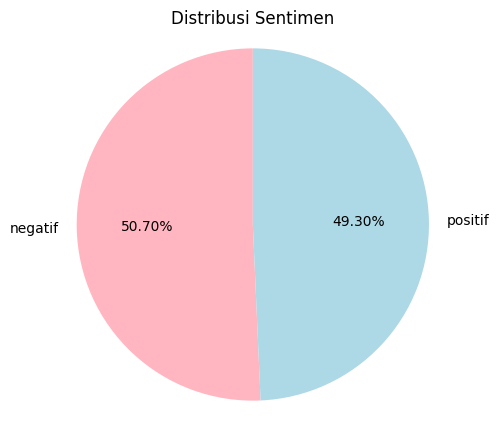

In [ ]:
sentiment_counts = data['sentiment'].value_counts()

# Colors
colors = ['#FFB6C1', '#ADD8E6']  # Light pink, light blue

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Modelling

## Model 1

In [ ]:
# Split data
X = data1['content']
y = data1['label']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=25, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=25, stratify=y_val
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1596
Validation set size: 342
Testing set size: 342


In [ ]:
from transformers import AutoTokenizer

# Inisialisasi tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=100
    )

train_encodings = tokenize_function(X_train)
val_encodings = tokenize_function(X_val)
test_encodings = tokenize_function(X_test)

In [ ]:
from torch.utils.data import Dataset # Import Dataset from torch.utils.data

class ReviewsDataset(Dataset):
    def __init__(self, encodings, label):
        self.encodings = encodings
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Check if idx is a list (for batching) or an integer (single item)
        if isinstance(idx, list):
            # If idx is a list, create a batch of items
            item = {key: torch.tensor([val[i] for i in idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor([self.label[i] for i in idx])
        else:
            # If idx is an integer, get a single item
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor(self.label[idx])
        return item

train_dataset = ReviewsDataset(train_encodings, y_train.tolist())
val_dataset = ReviewsDataset(val_encodings, y_val.tolist())
test_dataset = ReviewsDataset(test_encodings, y_test.tolist())

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler
from transformers import AutoTokenizer
from transformers import BertConfig
from torch.optim import AdamW # Import AdamW from torch.optim
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2, seed = 25)

# Inisialisasi model
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", config = config)

# Buat optimizer AdamW
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# Scheduler learning rate
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=3 * len(train_dataset) // 32
)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=3e-5,
    eval_strategy='epoch',
    save_strategy='epoch'
)

# Inisialisasi trainer dengan optimizer dan scheduler custom
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics, # Pass the defined function
    optimizers=(optimizer, lr_scheduler)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.543500,0.461016,0.885965,0.877743,0.958904,0.809249
2,0.258800,0.253052,0.903509,0.911528,0.850000,0.982659
3,0.232200,0.165409,0.938596,0.939481,0.936782,0.942197


TrainOutput(global_step=150, training_loss=0.3816517361005147, metrics={'train_runtime': 110.3716, 'train_samples_per_second': 43.381, 'train_steps_per_second': 1.359, 'total_flos': 152550967675680.0, 'train_loss': 0.3816517361005147, 'epoch': 3.0})

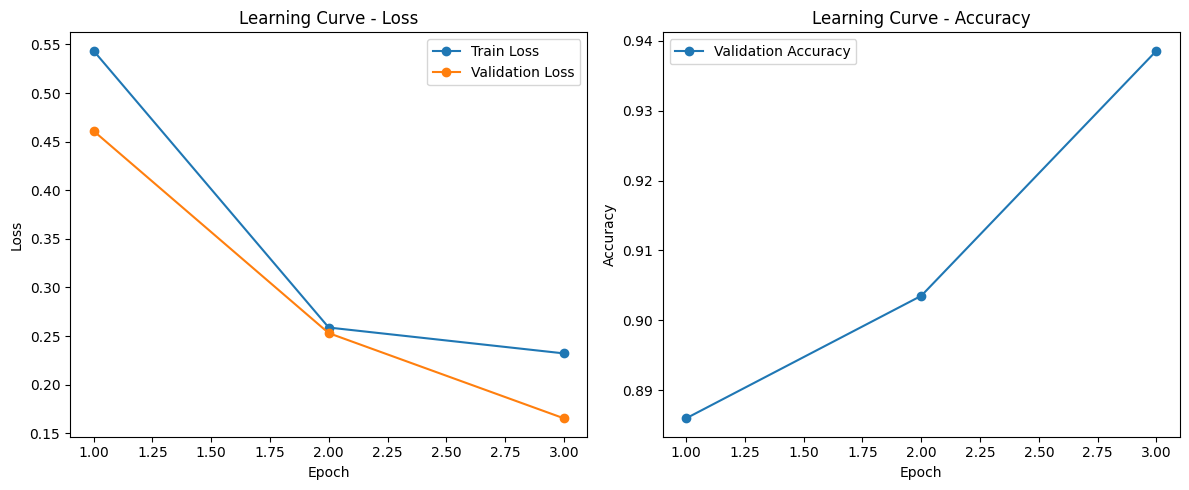

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

# List untuk menyimpan data per epoch
train_epochs = []
train_loss = []

eval_epochs = []
eval_loss = []
eval_accuracy = []

# Ekstrak data dari log_history
for log in log_history:
    # Training loss per epoch
    if 'loss' in log and 'epoch' in log:
        train_epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    # Evaluation metrics per epoch
    if 'eval_loss' in log and 'epoch' in log:
        eval_epochs.append(log['epoch'])
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log and 'epoch' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss (Training & Validation)
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label='Training Loss', marker='o')
plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracy, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediksi pada data testing
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Nilai sebenarnya (ground truth)
y_true = predictions.label_ids

# Hitung test accuracy
test_accuracy = accuracy_score(y_true, y_pred)

# Tampilkan test accuracy
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9152046783625731


In [ ]:
cr = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("=== Classification Report ===")
print(cr)
print("=== Confusion Matrix (===")
print(cm)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       169
           1       0.91      0.92      0.92       173

    accuracy                           0.92       342
   macro avg       0.92      0.92      0.92       342
weighted avg       0.92      0.92      0.92       342

=== Confusion Matrix (===
[[154  15]
 [ 14 159]]


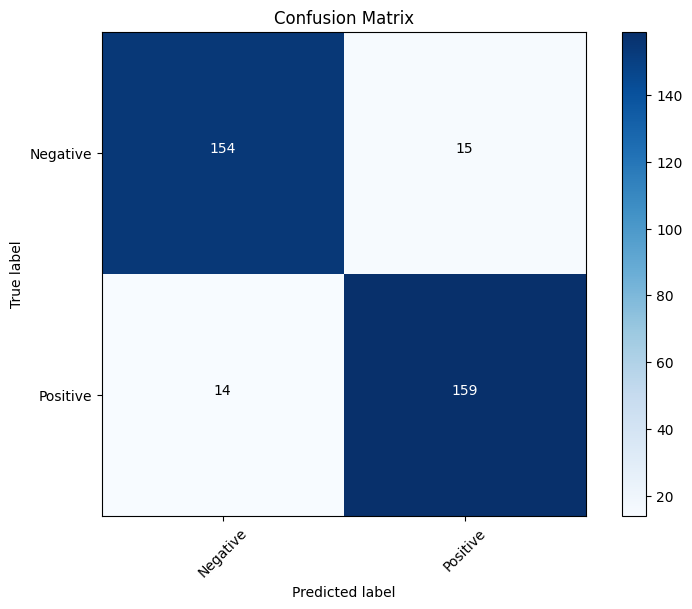

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model 2

In [ ]:
data.head()

,content,sentiment,label
0,Bagi yang tiba ada notifikasi aplikasi ilegal coba bale by BTN dihapus kemudian instal ulang Bagi yang username lupa bisa klik lupa ID Siapkan kartu ATM untuk isi data dan pulsa minimal ke Pastikan ingat MPIN Coba login lagi setelah jam Pastikan jaringan lancar Ini dari pengalaman saja kalau indak berhasil bisa langsung datang ke banknya,negatif,0
1,sudah antre bikin rekening sudah daftar isi formulir macam engak bisa daftar karena eror aplikasinya buang waktu saja,negatif,0
2,bagaimana Sih Nih Mau Registrasi saja Susah benar No Kartu saja benar kok Masa Dibilang Beda Bikin Ribet saja,negatif,0
3,sudah bayar mau service ac lewat apk byBTN dah buat janji tapi tukang ac nya engak ada konfirmasi sama sekali Duit engak balik engak bisa dibatalin juga Penipuan jangan pesan lewat sini engak jelas,negatif,0
4,sudah registrasi ulang terus di suruh login menit lagi di coba lagi login suruh registrasi lagi deh coba live chat jawaban engak menyambung di email juga jawaban sama juga di suruh registrasi lagi khn sudah beberapa kali registrasi payah,negatif,0


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=25):
    # Pengaturan untuk Python core
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

    # Pengaturan untuk NumPy
    np.random.seed(seed)

    # Pengaturan untuk TensorFlow
    tf.random.set_seed(seed)

    # Pengaturan tambahan untuk TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


    # Jika menggunakan GPU
    try:
        tf.config.experimental.set_memory_growth(
            tf.config.list_physical_devices('GPU')[0], True)
    except:
        pass

# Aplikasikan seed
set_seed(25)

# Jika menggunakan Keras, tambahkan ini:
from tensorflow import keras
keras.utils.set_random_seed(25)

In [ ]:
# Split data
X = data['content']
y = data['label']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=25, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=25, stratify=y_val
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1642
Validation set size: 352
Testing set size: 353


In [ ]:
from transformers import AutoTokenizer

# Inisialisasi tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=100
    )

train_encodings = tokenize_function(X_train)
val_encodings = tokenize_function(X_val)
test_encodings = tokenize_function(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset # Import Dataset from torch.utils.data
import torch

class ReviewsDataset(Dataset):
    def __init__(self, encodings, label):
        self.encodings = encodings
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Check if idx is a list (for batching) or an integer (single item)
        if isinstance(idx, list):
            # If idx is a list, create a batch of items
            item = {key: torch.tensor([val[i] for i in idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor([self.label[i] for i in idx])
        else:
            # If idx is an integer, get a single item
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor(self.label[idx])
        return item

train_dataset = ReviewsDataset(train_encodings, y_train.tolist())
val_dataset = ReviewsDataset(val_encodings, y_val.tolist())
test_dataset = ReviewsDataset(test_encodings, y_test.tolist())

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler, BertConfig
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Konfigurasi model
config = BertConfig.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=2,
    seed=25
)

model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    config=config
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Parameter training
train_batch_size = 32
num_train_epochs = 5
train_dataset_size = len(train_dataset)
total_training_steps = (train_dataset_size // train_batch_size) * num_train_epochs

# Scheduler LR
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_training_steps
)

# Fungsi evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# TrainingArguments dengan evaluasi per step dan save per step
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,

    # Penting: evaluasi dan save per step, agar load_best_model_at_end bisa jalan
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=10,
    save_steps=10,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    # Optional: untuk menghindari terlalu banyak checkpoint
    save_total_limit=3
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: haifamarwas (haifamarwas-universitas-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.733900,0.710896,0.528409,0.178218,0.642857,0.103448
20,0.719100,0.685770,0.553977,0.255924,0.729730,0.155172
30,0.667000,0.648731,0.602273,0.385965,0.814815,0.252874
40,0.634700,0.599731,0.752841,0.690391,0.906542,0.557471
50,0.579300,0.529765,0.906250,0.903790,0.917160,0.890805
60,0.484400,0.433929,0.920455,0.919075,0.924419,0.913793
70,0.388300,0.328447,0.934659,0.933333,0.941520,0.925287
80,0.318800,0.240510,0.934659,0.932153,0.957576,0.908046
90,0.200200,0.180623,0.954545,0.953488,0.964706,0.942529
100,0.181400,0.149156,0.954545,0.953216,0.970238,0.936782


TrainOutput(global_step=260, training_loss=0.2338948738689606, metrics={'train_runtime': 1191.4193, 'train_samples_per_second': 6.891, 'train_steps_per_second': 0.218, 'total_flos': 421902688380000.0, 'train_loss': 0.2338948738689606, 'epoch': 5.0})

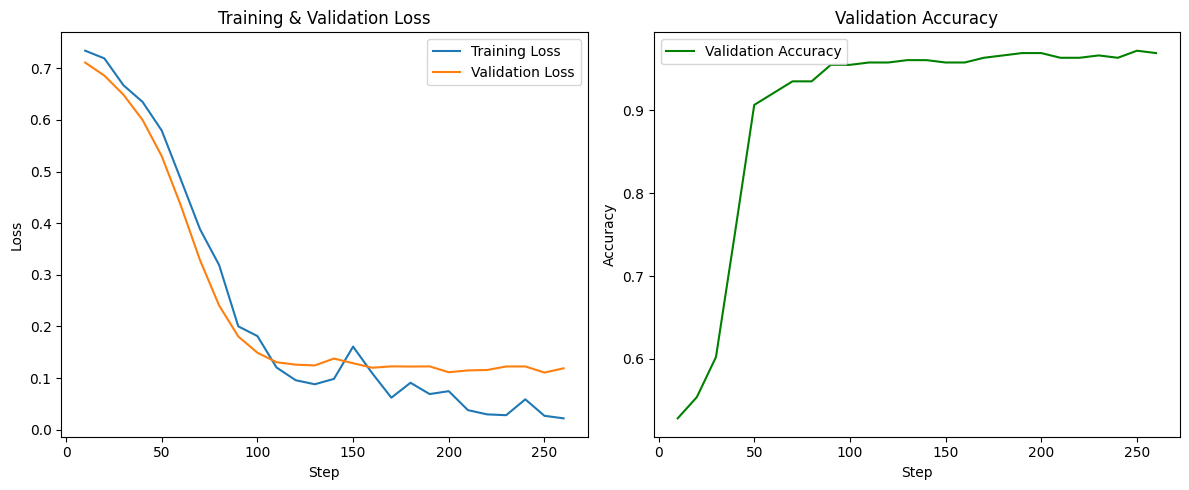

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

# List untuk menyimpan data
train_steps = []
train_loss = []

eval_steps = []
eval_loss = []
eval_accuracy = []

# Ekstrak data dari log_history
for log in log_history:
    # Training loss biasanya muncul saat step training
    if 'loss' in log and 'step' in log:
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    # Evaluation metrics muncul saat evaluasi
    if 'eval_loss' in log and 'step' in log:
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log and 'step' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss (Training & Validation)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Import Library Tambahan

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Prediksi pada Data Testing
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Menghitung dan Menampilkan Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9546742209631728


In [ ]:
# Classification Report

cr = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("=== Classification Report ===")
print(cr)
print("=== Confusion Matrix (===")
print(cm)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       179
           1       0.95      0.95      0.95       174

    accuracy                           0.95       353
   macro avg       0.95      0.95      0.95       353
weighted avg       0.95      0.95      0.95       353

=== Confusion Matrix (===
[[171   8]
 [  8 166]]


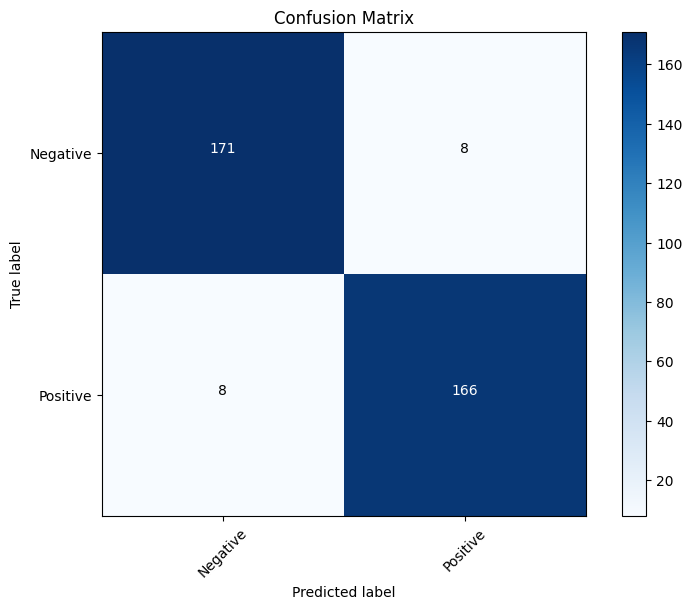

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model 3

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler, BertConfig
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Konfigurasi model
config = BertConfig.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=2,
    seed=25
)

model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    config=config
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Parameter training
train_batch_size = 32
num_train_epochs = 7
train_dataset_size = len(train_dataset)
total_training_steps = (train_dataset_size // train_batch_size) * num_train_epochs

# Scheduler LR
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_training_steps
)

# Fungsi evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# TrainingArguments dengan evaluasi per step dan save per step
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,

    # Penting: evaluasi dan save per step, agar load_best_model_at_end bisa jalan
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=10,
    save_steps=10,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    # Optional: untuk menghindari terlalu banyak checkpoint
    save_total_limit=3
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.729600,0.734138,0.431818,0.586777,0.458065,0.816092
20,0.718700,0.708212,0.468750,0.604651,0.478261,0.821839
30,0.692300,0.668344,0.605114,0.666667,0.572016,0.798851
40,0.647100,0.617460,0.789773,0.774390,0.824675,0.729885
50,0.593600,0.551079,0.857955,0.851190,0.882716,0.821839
60,0.507900,0.454359,0.889205,0.884273,0.914110,0.856322
70,0.417900,0.355961,0.920455,0.920455,0.910112,0.931034
80,0.339100,0.267440,0.928977,0.927954,0.930636,0.925287
90,0.233400,0.204406,0.937500,0.936416,0.941860,0.931034
100,0.205100,0.166032,0.946023,0.944928,0.953216,0.936782


TrainOutput(global_step=364, training_loss=0.1831974536206082, metrics={'train_runtime': 1665.3537, 'train_samples_per_second': 6.902, 'train_steps_per_second': 0.219, 'total_flos': 590663763732000.0, 'train_loss': 0.1831974536206082, 'epoch': 7.0})

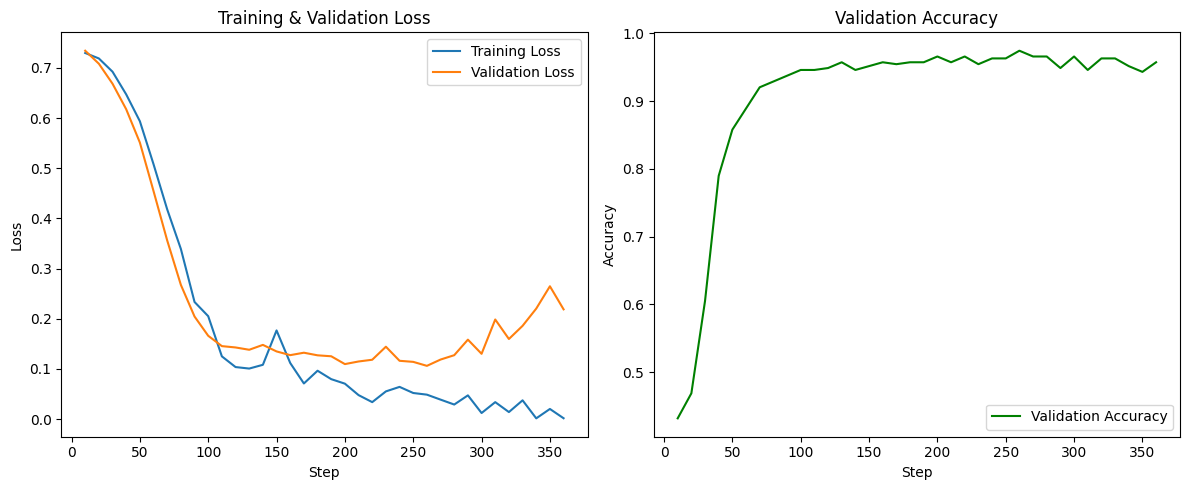

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

# List untuk menyimpan data
train_steps = []
train_loss = []

eval_steps = []
eval_loss = []
eval_accuracy = []

# Ekstrak data dari log_history
for log in log_history:
    # Training loss biasanya muncul saat step training
    if 'loss' in log and 'step' in log:
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    # Evaluation metrics muncul saat evaluasi
    if 'eval_loss' in log and 'step' in log:
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log and 'step' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss (Training & Validation)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediksi pada Data Testing
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Menghitung dan Menampilkan Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9546742209631728


In [ ]:
# Classification Report

cr = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("=== Classification Report ===")
print(cr)
print("=== Confusion Matrix (===")
print(cm)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       179
           1       0.96      0.95      0.95       174

    accuracy                           0.95       353
   macro avg       0.95      0.95      0.95       353
weighted avg       0.95      0.95      0.95       353

=== Confusion Matrix (===
[[172   7]
 [  9 165]]


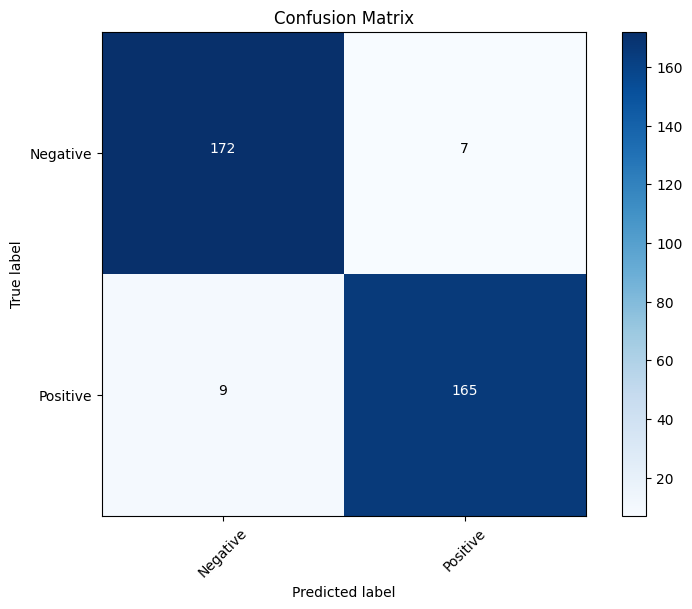

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model 4

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=25):
    # Pengaturan untuk Python core
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

    # Pengaturan untuk NumPy
    np.random.seed(seed)

    # Pengaturan untuk TensorFlow
    tf.random.set_seed(seed)

    # Pengaturan tambahan untuk TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


    # Jika menggunakan GPU
    try:
        tf.config.experimental.set_memory_growth(
            tf.config.list_physical_devices('GPU')[0], True)
    except:
        pass

# Aplikasikan seed
set_seed(25)

# Jika menggunakan Keras, tambahkan ini:
from tensorflow import keras
keras.utils.set_random_seed(25)

In [ ]:
# Split data
X_eda = df_eda['eda']
y_eda = df_eda['label']

# Split dataset
X_eda_train, X_eda_val, y_eda_train, y_eda_val = train_test_split(
    X_eda, y_eda, test_size=0.3, random_state=25, stratify=y_eda
)

X_eda_val, X_eda_test, y_eda_val, y_eda_test = train_test_split(
    X_eda_val, y_eda_val, test_size=0.5, random_state=25, stratify=y_eda_val
)

print(f"Training set size: {X_eda_train.shape[0]}")
print(f"Validation set size: {X_eda_val.shape[0]}")
print(f"Testing set size: {X_eda_test.shape[0]}")

Training set size: 1642
Validation set size: 352
Testing set size: 353


In [ ]:
from transformers import AutoTokenizer

# Inisialisasi tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=100
    )

train_eda_encodings = tokenize_function(X_eda_train)
val_eda_encodings = tokenize_function(X_eda_val)
test_eda_encodings = tokenize_function(X_eda_test)

In [ ]:
from torch.utils.data import Dataset # Import Dataset from torch.utils.data
import torch

class ReviewsDataset(Dataset):
    def __init__(self, encodings, label):
        self.encodings = encodings
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Check if idx is a list (for batching) or an integer (single item)
        if isinstance(idx, list):
            # If idx is a list, create a batch of items
            item = {key: torch.tensor([val[i] for i in idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor([self.label[i] for i in idx])
        else:
            # If idx is an integer, get a single item
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['label'] = torch.tensor(self.label[idx])
        return item

train_eda_dataset = ReviewsDataset(train_eda_encodings, y_eda_train.tolist())
val_eda_dataset = ReviewsDataset(val_eda_encodings, y_eda_val.tolist())
test_eda_dataset = ReviewsDataset(test_eda_encodings, y_eda_test.tolist())

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler, BertConfig
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Konfigurasi model
config = BertConfig.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=2,
    seed=25
)

model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    config=config
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Parameter training
train_batch_size = 32
num_train_epochs = 5
train_dataset_size = len(train_dataset)
total_training_steps = (train_dataset_size // train_batch_size) * num_train_epochs

# Scheduler LR
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_training_steps
)

# Fungsi evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# TrainingArguments dengan evaluasi per step dan save per step
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,

    # Penting: evaluasi dan save per step, agar load_best_model_at_end bisa jalan
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=10,
    save_steps=10,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    # Optional: untuk menghindari terlalu banyak checkpoint
    save_total_limit=3
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_eda_dataset,
    eval_dataset=val_eda_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.763900,0.729023,0.428977,0.199203,0.324675,0.143678
20,0.724400,0.707301,0.471591,0.335714,0.443396,0.270115
30,0.709200,0.675487,0.571023,0.494983,0.592000,0.425287
40,0.663100,0.632954,0.690341,0.635452,0.760000,0.545977
50,0.611000,0.579035,0.781250,0.771513,0.797546,0.747126
60,0.545600,0.509669,0.832386,0.830946,0.828571,0.833333
70,0.491400,0.422927,0.852273,0.857923,0.817708,0.902299
80,0.413700,0.341881,0.897727,0.894118,0.915663,0.873563
90,0.304000,0.275969,0.917614,0.914956,0.934132,0.896552
100,0.261300,0.237762,0.923295,0.919881,0.950920,0.890805


TrainOutput(global_step=260, training_loss=0.2877014634700922, metrics={'train_runtime': 407.0406, 'train_samples_per_second': 20.17, 'train_steps_per_second': 0.639, 'total_flos': 244703559260400.0, 'train_loss': 0.2877014634700922, 'epoch': 5.0})

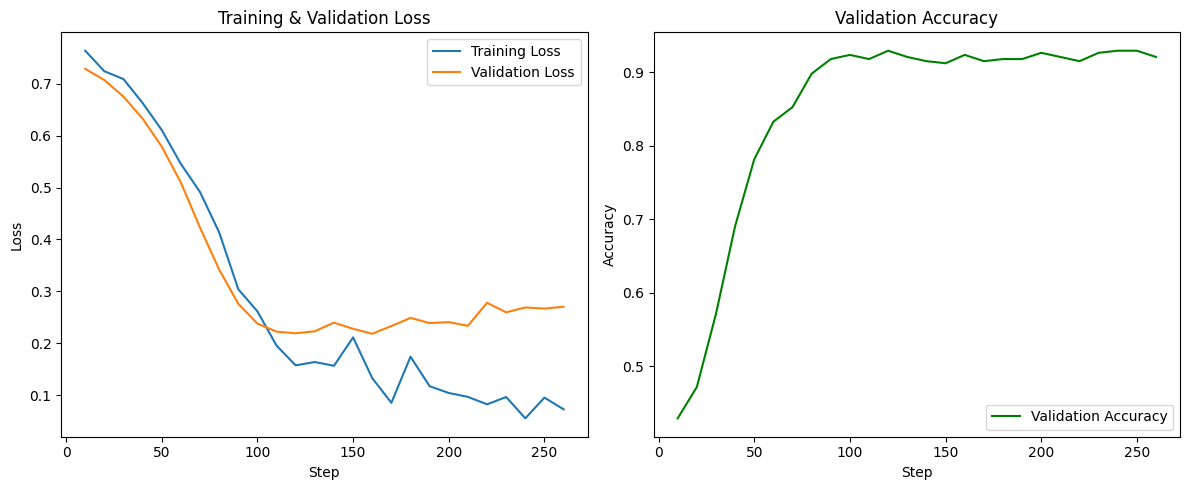

In [ ]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

# List untuk menyimpan data
train_steps = []
train_loss = []

eval_steps = []
eval_loss = []
eval_accuracy = []

# Ekstrak data dari log_history
for log in log_history:
    # Training loss biasanya muncul saat step training
    if 'loss' in log and 'step' in log:
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    # Evaluation metrics muncul saat evaluasi
    if 'eval_loss' in log and 'step' in log:
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log and 'step' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss (Training & Validation)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediksi pada Data Testing
predictions = trainer.predict(test_eda_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Menghitung dan Menampilkan Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9150141643059491


In [ ]:
# Classification Report

cr = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("=== Classification Report ===")
print(cr)
print("=== Confusion Matrix (===")
print(cm)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       179
           1       0.91      0.91      0.91       174

    accuracy                           0.92       353
   macro avg       0.91      0.91      0.91       353
weighted avg       0.92      0.92      0.92       353

=== Confusion Matrix (===
[[164  15]
 [ 15 159]]


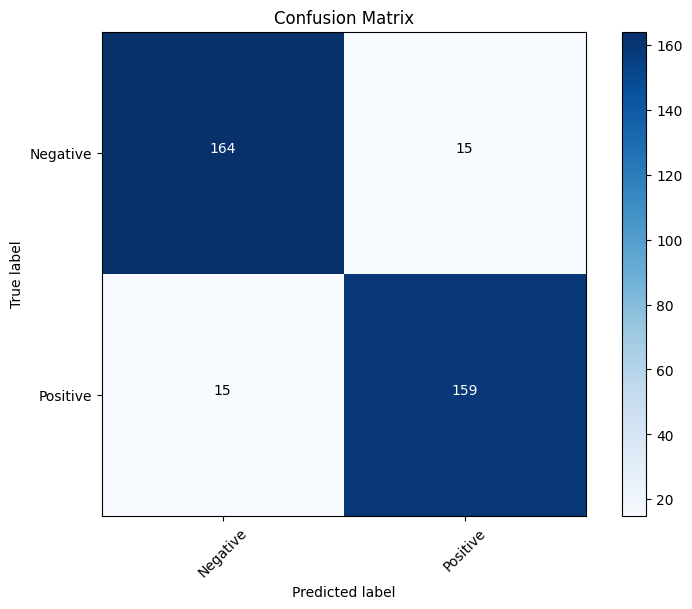

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()